# tentativo per trasformare una RNN in ungrafo di pyg per poter applicare la GNN a una rete neurale

In [21]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [2]:
class PyGModel(MessagePassing):
    def __init__(self):
        super(PyGModel, self).__init__(aggr='add')

        # Aggiungi qui il tuo modello PyTorch
        self.linear1 = torch.nn.Linear(in_features=3, out_features=4)
        self.linear2 = torch.nn.Linear(in_features=4, out_features=2)

    def forward(self, x, edge_index):
        # Aggiungi qui il codice per passare i dati attraverso la rete neurale
        x = self.linear1(x)
        x = self.linear2(x)
        return x


In [35]:
model = PyGModel()

# Genera dati di esempio
x = torch.randn(6, 3)
edge_index = torch.tensor([[0, 1, 2, 3, 4],
                           [1, 2, 3, 4, 0]], dtype=torch.long)
edge_index = torch.tensor([0, 1, 1, 2, 3, 3, 4, 5, 1, 0, 2, 1, 4, 5, 3, 3])

# Aggiungi un loop su se stesso al grafo
#edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
num_nodes = edge_index.max().item() + 1
data = Data(edge_index=edge_index, num_nodes=4)
# Calcola il grado dei nodi nel grafo
deg = degree(data.edge_index, num_nodes=num_nodes, dtype=torch.long)
deg_inv_sqrt = deg.pow(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

# Trasferisci il modello su un grafo
x = x * deg_inv_sqrt.view(-1, 1)
model = model.eval().to('cpu')
out = model(x, edge_index)


In [36]:
out

tensor([[-0.0567, -0.5463],
        [ 0.3662, -1.1178],
        [ 0.4617, -1.2609],
        [ 0.3815, -1.1626],
        [ 0.1862, -0.9162],
        [ 0.4960, -1.2685]], grad_fn=<AddmmBackward0>)

In [31]:
edge_index = torch.tensor([0, 1, 1, 2, 3, 3, 4, 5, 1, 0, 2, 1, 4, 5, 3, 3])
num_nodes = edge_index.max().item() + 1
data = Data(edge_index=edge_index, num_nodes=4)
# Calcola il grado dei nodi nel grafo
deg = degree(data.edge_index, num_nodes=num_nodes, dtype=torch.long)

In [32]:
deg

tensor([2, 4, 2, 4, 2, 2])

6


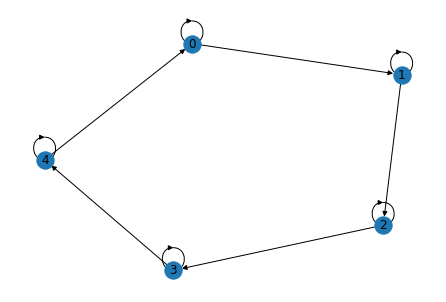

In [24]:
edge_index2 = torch.tensor([[0, 1, 1, 2, 3, 3, 4, 5], [1, 0, 2, 1, 4, 5, 3, 3]])
num_nodes = edge_index2.max().item() + 1
print(num_nodes)
data = Data(edge_index=edge_index, num_nodes=4)
G = to_networkx(data)
nx.draw(G, with_labels=True)
plt.show()

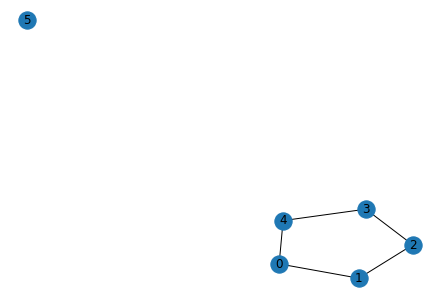

In [23]:
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edge_index.t().tolist())

# Plotta il grafo utilizzando matplotlib
nx.draw(G, with_labels=True)
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch_geometric

# Creazione della rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

# Estrarre i tensori di input e output della rete neurale
input_tensor = torch.randn(1, 4)
output_tensor = model(input_tensor)

# Creare un grafo vuoto
graph = torch_geometric.data.Data()

# Aggiungere i nodi al grafo
graph.x = torch.cat((input_tensor, output_tensor), dim=0)

# Iterare sui layer della rete neurale e aggiungere gli archi al grafo
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        weight_matrix = module.weight.data
        src, dst = weight_matrix.nonzero().t()
        edge_index = torch.stack([src + name, dst + name], dim=0)
        if graph.edge_index is None:
            graph.edge_index = edge_index
        else:
            graph.edge_index = torch.cat((graph.edge_index, edge_index), dim=1)

# Visualizzare il grafo
print(graph)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 4 but got size 2 for tensor number 1 in the list.

In [42]:
import torch
from torch import nn
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx

In [50]:
import torch.nn.functional as F

class myLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(myLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = x + self.bias
        return F.relu(x)


In [51]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList([myLinear(10, 5), nn.ReLU(), myLinear(5, 2), nn.ReLU(), myLinear(2, 1)])

    def forward(self, x):
        out = []
        for layer in self.layers:
            x = layer(x)
            out.append(x)
        return out

model = MyModel()

{}

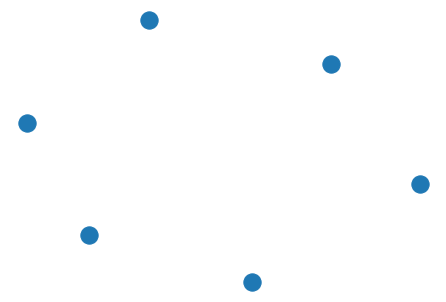

In [52]:
x = torch.randn(1, 10)

# Create graph
graph = nx.DiGraph()
# Add nodes for inputs and outputs
graph.add_node("input")
for i in range(len(model.layers)):
    graph.add_node(f"output_{i}")
# Add edges for weights
for i, layer in enumerate(model.layers):
    if isinstance(layer, nn.Linear):
        weight_matrix = layer.weight.data
        for j in range(weight_matrix.shape[0]):
            for k in range(weight_matrix.shape[1]):
                graph.add_edge(f"output_{i-1}" if i>0 else "input", f"output_{i}", weight=weight_matrix[j,k].item())
        
# Convert to PyG data
#data = to_networkx(graph)
data = from_networkx(graph)

# Plot graph
pos = nx.spring_layout(graph)
nx.draw(graph, pos)
nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)})

In [81]:
myLinear

__main__.myLinear

In [105]:
# Creiamo una lista vuota per contenere i grafi
graph_list = []


# Aggiungiamo il grafo iniziale con i tensori di input come nodi
input_nodes = [torch.zeros(10), torch.zeros(10)]
input_edges = [(0, 2), (1, 2)]
input_graph = Data(x=torch.stack(input_nodes), edge_index=torch.tensor(input_edges).t().contiguous())
graph_list.append(input_graph)
input_nodes

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [102]:
# Aggiungiamo i grafi intermedi con i tensori di output come nodi
ll = list(model.children())[0]
for i, layer in enumerate(ll):
    print('layer')
    if isinstance(layer, myLinear):        
        # Recuperiamo i tensori di input e output del layer
        if i == 0:
            input_tensors = input_nodes
        else:
            input_tensors = graph_list[-1].x
        output_tensors = [layer(tensor) for tensor in input_tensors]

        # Creiamo un grafo con i tensori di output come nodi e gli archi ricavati dalla matrice dei pesi
        weight_matrix = layer.weight.detach().numpy()
        print(f"weight_matrix: {weight_matrix.shape}")
        output_nodes = output_tensors
        output_edges = [(j, k) for j in range(len(input_tensors)) for k in range(len(output_tensors))]
        print(len(input_tensors), len(output_tensors))
        edge_weights = [weight_matrix[j, k] for j in range(len(input_tensors)) for k in range(len(output_tensors))]
        output_graph = Data(x=torch.stack(output_nodes), edge_index=torch.tensor(output_edges).t().contiguous(), edge_attr=torch.tensor(edge_weights))
        graph_list.append(output_graph)

# Aggiungiamo il grafo finale con i tensori di output come nodi
output_nodes = [torch.zeros(4), torch.zeros(4)]
output_edges = [(j, 0) for j in range(len(graph_list[-1].x))]
output_graph = Data(x=torch.stack(output_nodes), edge_index=torch.tensor(output_edges).t().contiguous())
graph_list.append(output_graph)

# Uniamo tutti i grafi in un unico oggetto di tipo `Data`
#data = Data.from_data_list(graph_list)
G = nx.DiGraph()
for g in graph_list:
    print(g.edge_index)
    G.add_edges_from(g.edge_index.numpy().T)

print(data)

layer
weight_matrix: (10, 5)
2 2
layer
layer
weight_matrix: (5, 2)
2 2
layer
layer
weight_matrix: (2, 1)
2 2


IndexError: index 1 is out of bounds for axis 1 with size 1

In [92]:
list(model.children())[0]

ModuleList(
  (0): myLinear()
  (1): ReLU()
  (2): myLinear()
  (3): ReLU()
  (4): myLinear()
)

In [90]:
l = list(model.children())[0][0]
isinstance(l, myLinear)

True

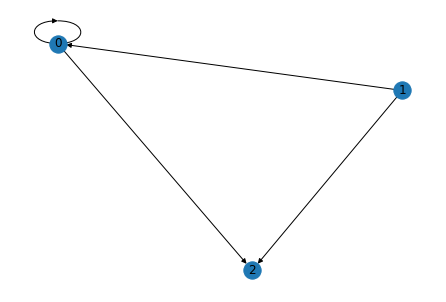

In [78]:
nx.draw(G, with_labels=True)
plt.show()